# Building prediction models using the created embeddings

This notebook is a step-by-step guide to create multiple prediction models with the created embeddings. The code can be runned after creating the embedding using the GLACE train.py file

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Read in network embedding and price labels

In [55]:
# Network embedding generated by GLACE
ps = pd.read_pickle('GLACE/emb/glace_cora_ml_embedding_first-order_Full_graph_all_nodes.pkl')
len(ps["mu"])

17838

In [4]:
ps

{'mu': {0: array([ 0.18030894, -0.5059033 , -0.00851729, -0.24164718,  0.58373743,
          0.19648188, -0.26709104,  0.24960062, -0.09581421, -0.46694848,
         -0.29264072, -0.38066146, -0.03069183, -0.14553961,  0.09743093,
          0.07533219, -0.54401517, -0.07322112, -0.02239041, -0.2722342 ,
          0.5167869 ,  0.4970684 , -0.08768485,  0.0058886 , -0.02951376,
          0.36009303,  0.4520915 , -0.24540038,  0.22622496,  0.27987307,
          0.64680755, -0.03172544,  0.27340773, -0.30949473,  0.3467583 ,
         -0.35153508, -0.00760296, -0.05154143, -0.28095084, -0.03940722,
          0.34425598,  0.27365324, -0.32658014,  0.05166146, -0.53965086,
         -0.13311604,  0.05118235, -0.05076289, -0.42337757,  0.05763473,
          0.12880467, -0.4357456 ,  0.01661193,  0.4067613 , -0.01812185,
          0.74705493,  0.09061678, -0.6338649 , -0.04413445,  0.14604916,
          0.02278592,  0.15989213,  0.13849759, -0.14650443], dtype=float32),
  1: array([ 0.1566863 , 

In [5]:
# Example of the content of the network embedding for node 2.
print("mu of node 2: ", ps["mu"][2])
print(100*"*")
print("sigma of node 2: ", ps["sigma"][2])

mu of node 2:  [ 0.24923146 -0.5882417  -0.00556844 -0.37703618  0.68580693  0.18442476
 -0.2328648   0.14446214 -0.15693274 -0.26414704 -0.18019035 -0.23689249
 -0.06533585  0.2634202   0.10609251  0.07452506 -0.57499737  0.0682862
 -0.10078213 -0.29299566  0.2556958   0.30005407 -0.09974638  0.00477307
  0.01836844  0.18000418  0.355888   -0.13340239 -0.01914509  0.28368336
  0.57492685 -0.23639187  0.2108871   0.06024044  0.51874363 -0.4432908
  0.04760991  0.06346536 -0.24698675 -0.1722193   0.49004441  0.17019063
 -0.2741575   0.19727433 -0.5534226  -0.16035374  0.11575244  0.04080293
 -0.6461332  -0.08325183  0.2769183  -0.2029243   0.15184018  0.31080037
 -0.10335699  0.7835978   0.23287916 -0.5334842  -0.0236844   0.32699308
  0.02938545 -0.02743985  0.08012632 -0.25112554]
****************************************************************************************************
sigma of node 2:  [3.3970373  0.8646948  1.3434542  1.0802047  0.85631144 2.4174666
 1.182814   0.91166145

In [56]:
labels = pd.read_csv("price_label_sample.csv")
labels

,price,index
0,221900.0,0
1,538000.0,1
2,180000.0,2
3,604000.0,3
4,510000.0,4
...,...,...
17833,475000.0,21607
17834,360000.0,21608
17835,400000.0,21609
17836,402101.0,21610


## Preprocessing
The embedding file is a dictionary file, this needs to be converted into a right format for the ML model to be able to train on it.
1) Can convert the training data to a numpy array.
2) Can construct a new dataframe which it could use.

In [57]:
# Change the code to make it more generalizable to take 20% as a test set. 200 has to be changed
test_size = round(len(labels)*0.2)
X_train =  np.array([np.array(ps['mu'][k]) for k in range(0, len(ps['mu']) - test_size)])
X_test = np.array([np.array(ps['mu'][k]) for k in range(len(ps['mu']) - test_size, len(ps['mu']))])

In [58]:
y_train =  np.array([np.array(labels['price'][k]) for k in range(0, len(labels['price']) - test_size)])
y_test = np.array([np.array(labels['price'][k]) for k in range(len(labels['price']) - test_size, len(labels['price']))])

### First let's do some exploration of the target variable (price) distribution

Investigate the distribution of the target variable. 

c:\Users\Yarne\miniconda3\envs\tf1.15\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.



 mu = 534016.01 and sigma = 367157.87



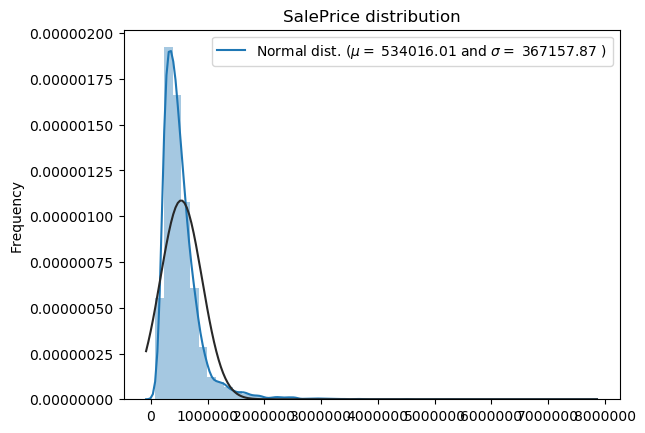

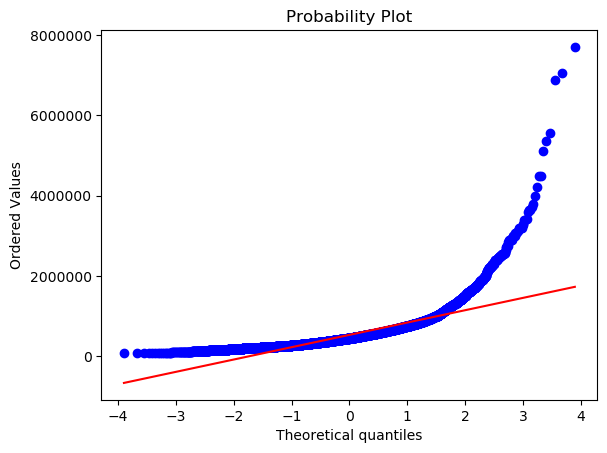

In [11]:
sns.distplot(y_train , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

The distribution of the target variable is skewed. This could affect the performance of the prediction models

Perform log-transformation on the target variable in the training and test set.

c:\Users\Yarne\miniconda3\envs\tf1.15\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """



 mu = 13.04 and sigma = 0.53



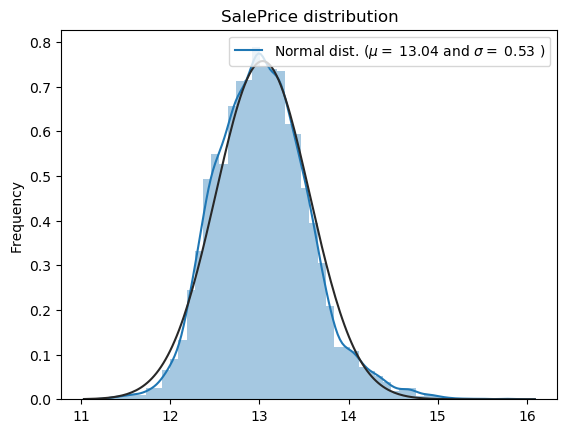

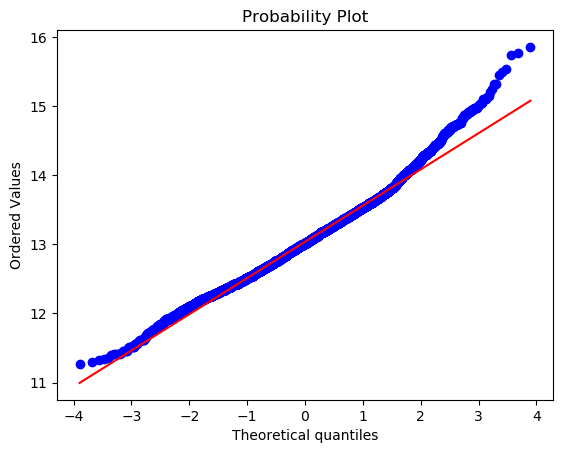

In [12]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 13.11 and sigma = 0.52



c:\Users\Yarne\miniconda3\envs\tf1.15\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


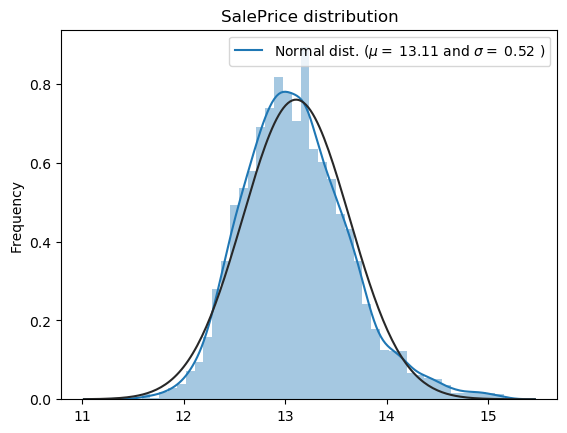

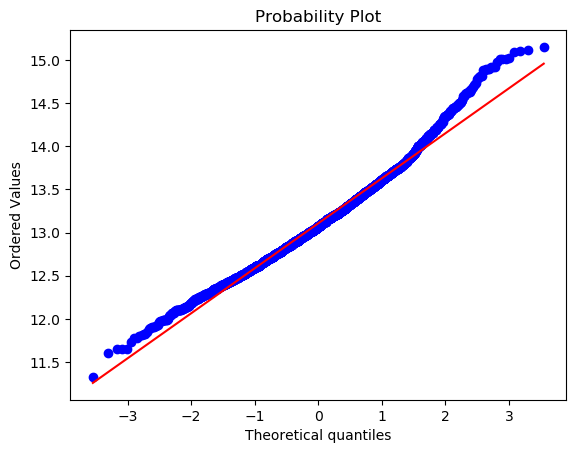

In [13]:
#We use the numpy fuction log1p which applies log(1+x) to all elements of the column
y_test = np.log1p(y_test)

#Check the new distribution 
sns.distplot(y_test , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_test, plot=plt)
plt.show()

## Modeling with network embedding - GLACE

Define MAPE metric, this will be used in addition to MAE and RMSE to evaluate the models

In [14]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [86]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = linreg.predict(X_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
print('R-squared|', linreg.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
print('R-squared|', linreg.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')


Results of test set
R-squared| 0.806075629762649
RMSE_test| 0.231
MAE_test | 0.1769
MAPE_test| 1.35 %
****************************************************************************************************
Results of training set
R-squared| 0.8045525286697186
RMSE_train| 0.2329
MAE_train | 0.178
MAPE_train| 1.37 %


We should check for the following conditions to check what is going wrong with the prediction of the models:
1) Class imbalance, uneven distirbution. Need to plot the distribution and ptoentially nromalize it. -- Lognormalizing this does have a signifant increase in performance of the model too.
2) High non-linearity, then we need to use another model to see if it has the same consequence -- IT SEEMS LIKE THIS WAS THE CASE!
3) Overfitting, seems weird. Could check by taking a larger dataset or using regularization.

Crossvalidation of Linreg


In [181]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linreg, X_train, y_train, cv=5)
scores.mean()


0.6477623591176845

XGBoost (eval set isn't used since this doesn't work)


In [15]:

XGBR = XGBRegressor(objective = 'reg:squarederror')
grid_param = {'n_estimators': [200,400,500],
              'max_depth': [3,4,5],
              'learning_rate' : [0.01,0.02]
              }
grid_mse = GridSearchCV(estimator = XGBR, param_grid = grid_param, scoring = "neg_mean_squared_error", cv = 5, verbose = 1)
grid_mse.fit(X_train, y_train,verbose=True)
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found:  {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 500}
Lowest RMSE found:  0.17368796065181796


In [19]:
XGBR = XGBRegressor(n_estimators = 1000, objective = 'reg:squarederror', max_depth = 7, learning_rate = 0.02)



XGBR.fit(X_train, y_train,verbose=True)

y_pred = XGBR.predict(X_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = XGBR.predict(X_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
print('R-squared|', XGBR.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
print('R-squared|', XGBR.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')

Results of test set
R-squared| 0.8988004948567895
RMSE_test| 0.1669
MAE_test | 0.1224
MAPE_test| 0.93 %
****************************************************************************************************
Results of training set
R-squared| 0.9682968656815412
RMSE_train| 0.0938
MAE_train | 0.0696
MAPE_train| 0.54 %


XGBoost using linear based learner. This one gives better performance in our case

In [88]:
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test =  xgb.DMatrix(data = X_test, label = y_test)
# Create the parameter dictionary: params
params = {"objective":"reg:squarederror","max_depth":5, "eta":0.02} #Best yet, do gridsearch later

xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10000)

y_pred = xg_reg.predict(DM_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = xg_reg.predict(DM_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
#print('R-squared|', xg_reg.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
#print('R-squared|',xg_reg.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')

Results of test set
RMSE_test| 0.1888
MAE_test | 0.145
MAPE_test| 1.11 %
****************************************************************************************************
Results of training set
RMSE_train| 0.0275
MAE_train | 0.0201
MAPE_train| 0.16 %


Crossvalidation of tree-based XGBoost

In [80]:
scores = cross_val_score(XGBR, X_train, y_train, cv=5)
scores.mean() # Need to check if this is normal without hyperparameter tuning etc. Check this in contrast to using a classical approach to estimating the model performance.
# Note also that this is a very small dataset of 1000 instances, it has trained on approx 800 and tests on 200, so it is somewhat normal that the score is low.

0.5586960249031954

Random Forest

In [89]:
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = rf.predict(X_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
print('R-squared|', rf.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
print('R-squared|',rf.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')

Results of test set
R-squared| 0.8869472124188826
RMSE_test| 0.1764
MAE_test | 0.1281
MAPE_test| 0.98 %
****************************************************************************************************
Results of training set
R-squared| 0.9837655189858626
RMSE_train| 0.0671
MAE_train | 0.0484
MAPE_train| 0.37 %


Crossvalidation of Random Forest

In [137]:
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores.mean()

0.5870924983556047

## Modelling without network embedding - only using raw features

Feature engineering is not included yet with regards to geospatial information like amount of houses in certain proximity.
(Currently using the dataset without zipcode) 

Modelling including spatial features will be added in next section

In [164]:
base_df = pd.read_csv("BaseKC_data.csv")
#base_df = base_df.drop(["id"], axis=1)
base_df = base_df.drop(["index"], axis=1)
#Test of dit invloed heeft --> ONLY removing index gives best results
base_df

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,is_renovated
0,1,6414100192,538000.0,0.090909,0.409091,0.227508,0.021056,0.5,0.0,0.0,0.50,0.333333,0.246238,0.114286,0.443478,47.7210,-122.319,0.217699,0.045583,1.0
1,3,2487200875,604000.0,0.121212,0.545455,0.164426,0.013894,0.0,0.0,0.0,1.00,0.333333,0.093023,0.260000,0.565217,47.5208,-122.393,0.159292,0.028346,0.0
2,11,9212900260,468000.0,0.060606,0.181818,0.081696,0.017088,0.0,0.0,0.0,0.75,0.333333,0.067031,0.085714,0.365217,47.6900,-122.292,0.153982,0.034878,0.0
3,13,6054650070,400000.0,0.090909,0.318182,0.103413,0.028845,0.0,0.0,0.0,0.75,0.333333,0.136799,0.000000,0.669565,47.6127,-122.045,0.161062,0.062362,0.0
4,19,7983200060,230000.0,0.090909,0.181818,0.091003,0.029145,0.0,0.0,0.0,0.75,0.333333,0.120383,0.000000,0.600000,47.3343,-122.306,0.145133,0.053492,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,21569,6021503705,329000.0,0.060606,0.454545,0.063082,0.001179,1.0,0.0,0.0,0.50,0.444444,0.083447,0.000000,0.939130,47.6844,-122.387,0.092035,0.002371,0.0
2989,21577,3881900317,579000.0,0.121212,0.590909,0.158221,0.006325,0.5,0.0,0.0,0.50,0.555556,0.120383,0.185714,0.991304,47.5869,-122.311,0.221239,0.025094,0.0
2990,21595,1972201967,520000.0,0.060606,0.409091,0.119959,0.001054,1.0,0.0,0.0,0.50,0.444444,0.151847,0.014286,0.921739,47.6533,-122.346,0.189381,0.004063,0.0
2991,21601,5100403806,467000.0,0.090909,0.454545,0.109100,0.001687,1.0,0.0,0.0,0.50,0.444444,0.144323,0.000000,0.939130,47.6963,-122.318,0.146018,0.003873,0.0


In [165]:
X = base_df.drop(["price"], axis=1)
y = base_df["price"]
#Toegevoegd om zelfde format te hebben als embedding, geen invloed op results
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

Normalizing prices


In [166]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

Linear Regression


In [167]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = linreg.predict(X_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
print('R-squared|', linreg.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
print('R-squared|', linreg.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')


Results of test set
R-squared| 0.7672550114934291
RMSE_test| 0.2617
MAE_test | 0.2005
MAPE_test| 1.53 %
****************************************************************************************************
Results of training set
R-squared| 0.7848771437748774
RMSE_train| 0.2426
MAE_train | 0.1877
MAPE_train| 1.44 %


XGBoost

In [168]:
XGBR = XGBRegressor(n_estimators = 100, objective = 'reg:squarederror')
XGBR.fit(X_train, y_train)

y_pred = XGBR.predict(X_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = XGBR.predict(X_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
print('R-squared|', XGBR.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
print('R-squared|', XGBR.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')

Results of test set
R-squared| 0.8767701662334105
RMSE_test| 0.1904
MAE_test | 0.1384
MAPE_test| 1.06 %
****************************************************************************************************
Results of training set
R-squared| 0.9954144808467397
RMSE_train| 0.0354
MAE_train | 0.0255
MAPE_train| 0.2 %


XGBoost using linear based learner


In [169]:
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test =  xgb.DMatrix(data = X_test, label = y_test)
# Create the parameter dictionary: params
params = {"objective":"reg:squarederror","max_depth":5, "eta":0.02} #Best yet, do gridsearch later

xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10000)

y_pred = xg_reg.predict(DM_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = xg_reg.predict(DM_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
#print('R-squared|', xg_reg.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
#print('R-squared|',xg_reg.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')

Results of test set
RMSE_test| 0.1816
MAE_test | 0.1292
MAPE_test| 0.99 %
****************************************************************************************************
Results of training set
RMSE_train| 0.0024
MAE_train | 0.0016
MAPE_train| 0.01 %


Random Forest

In [55]:
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
#Test set results
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = MAPE(y_test,y_pred)
#Training set results
y_pred_tr = rf.predict(X_train)
rmse_tr = mean_squared_error(y_train, y_pred_tr, squared=False)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
mape_tr = MAPE(y_train, y_pred_tr)
print('Results of test set')
print('R-squared|', rf.score(X_test, y_test))
print('RMSE_test|', round(rmse,4))
print('MAE_test |', round(mae,4))
print('MAPE_test|', round(mape,2), '%')
print('*'*100)
print('Results of training set')
print('R-squared|',rf.score(X_train, y_train))
print('RMSE_train|', round(rmse_tr,4))
print('MAE_train |', round(mae_tr,4))
print('MAPE_train|', round(mape_tr,2), '%')

Results of test set
R-squared| 0.8798424270206349
RMSE_test| 0.1807
MAE_test | 0.1338
MAPE_test| 1.02 %
****************************************************************************************************
Results of training set
R-squared| 0.9820101613624022
RMSE_train| 0.0708
MAE_train | 0.0515
MAPE_train| 0.4 %


# RAW + GLACE, after this run models again

In [2]:
ps = pd.read_pickle('GLACE/emb/glace_cora_ml_embedding_first-order_Full_graph_all_nodes.pkl')
labels = pd.read_csv("price_label_sample.csv")
base_df = pd.read_csv("BaseKC_data.csv")
len(ps["mu"])

17838

In [3]:
test_size = round(len(labels)*0.2)
X_train =  np.array([np.array(ps['mu'][k]) for k in range(0, len(ps['mu']) - test_size)])
X_test = np.array([np.array(ps['mu'][k]) for k in range(len(ps['mu']) - test_size, len(ps['mu']))])

y_train =  np.array([np.array(labels['price'][k]) for k in range(0, len(labels['price']) - test_size)])
y_test = np.array([np.array(labels['price'][k]) for k in range(len(labels['price']) - test_size, len(labels['price']))])

Convert 2D numpy array to pandas dataframes

In [4]:
X_train = pd.DataFrame(X_train.tolist(), columns=["col_" + str(i) for i in range(X_train.shape[1])])
X_test = pd.DataFrame(X_test.tolist(), columns=["col_" + str(i) for i in range(X_test.shape[1])])

In [5]:
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)
print("base_Df shape: ", base_df.shape)

train shape:  (14270, 64)
test shape:  (3568, 64)
base_Df shape:  (17838, 21)


Give correct shape to Raw data

In [6]:
base_df_train = base_df.head(14270)
base_df_train.shape

(14270, 21)

In [7]:
base_df_test = base_df.tail(3568)
base_df_test.reset_index(drop=True, inplace=True)
base_df_test.shape

(3568, 21)

Concatenate the dataframe containing the values of the network embedding and the data from the raw dataframe - RAW + GLACE

In [8]:
X_train_concatenated = pd.concat([X_train, base_df_train], axis=1)
X_test_concatenated = pd.concat([X_test, base_df_test], axis=1)

In [9]:
X_train_concatenated.drop(["price"], inplace=True, axis=1)
X_test_concatenated.drop(["price"], inplace=True, axis=1)

Run to avoid modifying code up above

In [10]:
X_train = X_train_concatenated
X_test = X_test_concatenated
